# Minimum Variance Portfolio, sample cov using MLE linear shrinkage

Shrinkage algorithm implemented from 
    Ledoit, O., and M. Wolf, 2003, “Honey, I Shrunk the Sample Covariance Matrix,” Working
    Paper, Department of Economics and Business, Universitat Pompeu Fabra.
Access: https://ssrn.com/abstract=433840

The performance of the shrinkage estimator is measured in MSE terms of the covariance matrix estimate, using the matrix Frobenius norm

$ ||\hat{\Sigma}-\Sigma||_F = \sqrt{\sum_{i,j} (\hat{\sigma}^2_{ij} - \sigma^2_{ij})^2 }$.
 That is, the squared residual of the element-wise covariances.
 
While the shrinkage estimator is a biased estimator, it can archive a lower MSE than the unbiased sample covariance by having a lower variance.

## Define benchmark returns statistics

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import scipy.stats as stats
import putils
import montecarlo as mc
import pmontecarlo as pmc
import present

# =========================
# ===== Daily Returns =====
# =========================
# Some 4 OMX stocks....
mcorr = np.array(
    [
        [1.00, 0.26, 0.41, 0.57],
        [0.26, 1.00, 0.19, 0.33],
        [0.41, 0.19, 1.00, 0.52],
        [0.57, 0.33, 0.52, 1.00]
    ])

vol = np.array([0.01531293, 0.01802784, 0.02480944, 0.01251876])
vol = vol / vol
mcov = np.diag(vol) @ mcorr @ np.diag(vol)

## Calculate measures based on benchmark return distribution

In [2]:
# TODO: move outside of main
# Used for estimating hedged portfolio variance, involing inverse of covariance matrix.
p = putils.Portfolio(np.array([1, 0, 0, 0]))
p_var = putils.portfolio_var(p, mcov)
hdg = putils.mvp_hedge(p, mcov)
mvp = p + hdg
mvp_var = putils.portfolio_var(mvp, mcov)

print((1-mvp_var/p_var)**0.5)

p1 = putils.Portfolio(mvp.pos)
p1.pos[1] = 0
p1.pos[2] = 0
v1 = putils.portfolio_var(p1, mcov)
print(v1 / p_var)


# === Covariance Frobenius Norm ===
norm_exact = np.linalg.norm(mcov, 'fro')

truevals = {'mvp.var':mvp_var, 'cov.relnorm':norm_exact, 'p.var':p_var}
print(hdg.pos)
#print(hdg.pos.sum() / (vol[0] + vol[3]))
# Sum of hedge positions = hdg.pos.sum() / (vol[0] + vol[3])


0.5898633534654071
0.686236035808219
[ 0.         -0.07751213 -0.15374695 -0.46447258]


## Simulate returns and estimate MVP

In [3]:
obs_gen = stats.multivariate_normal(cov=mcov)
T_grid = pmc.init_sparse_grid(lbound=mcorr.shape[0], max_sample_size = 60)
mc = mc.MonteCarlo(
    rndgen=lambda: obs_gen.rvs(T_grid[-1]),
    nsim=1000,
    evalfunc=lambda welfords,path : pmc.mc_path_eval(T_grid, p, mcov, welfords, path),
    welfords=pmc.estimations(len(T_grid))
    )
est = mc.run()

## Results

No handles with labels found to put in legend.
No handles with labels found to put in legend.


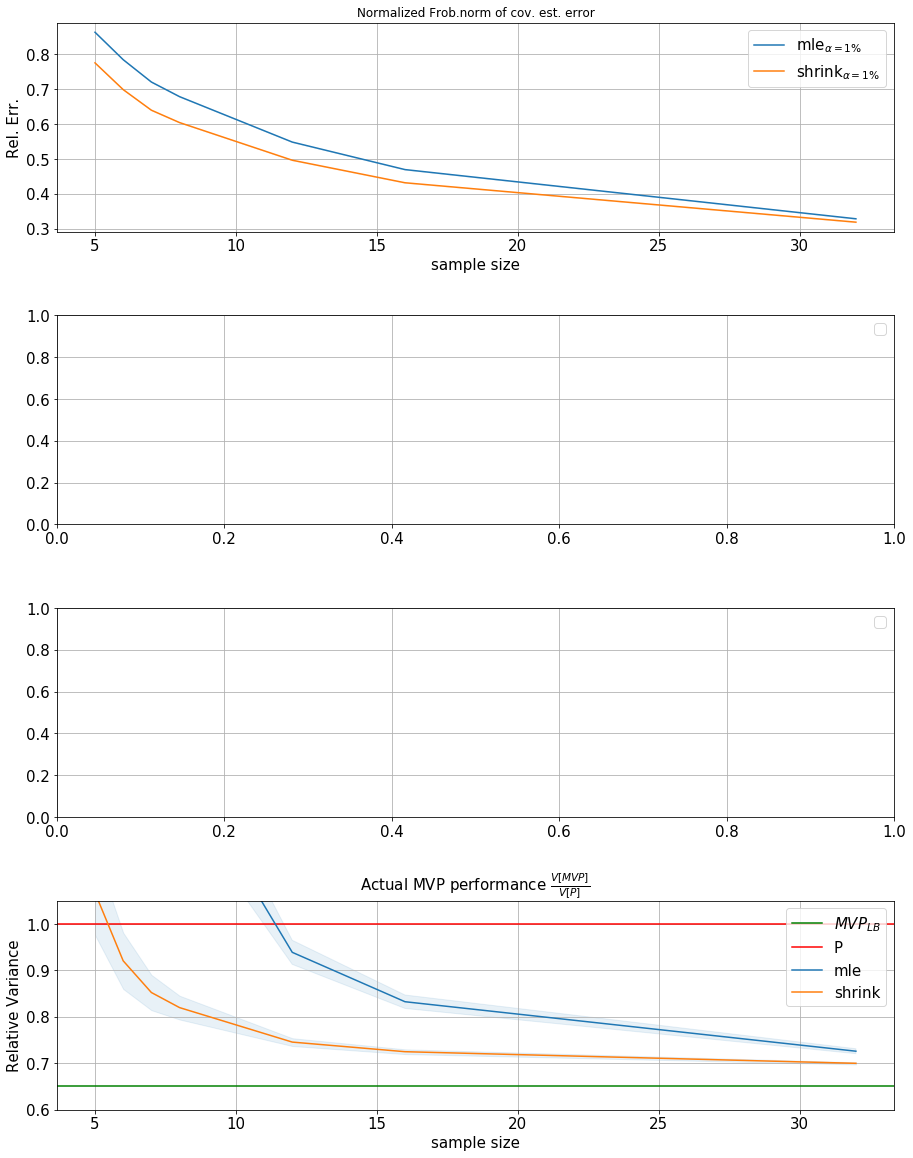

In [4]:
present.result(T_grid, est, truevals, alpha_conf = 0.01)

Sharpe P: 0.06530428859793652
Bank P: 10.0
========= Theory Hedge =========
weights: [10000.  -658.  -949. -5681.]
Sharpe: 0.06908273959448674
HdgCost: 14.58%
VarRem: 65.21%

========= Optim =========
Optimization terminated successfully.
         Current function value: -0.071175
         Iterations: 335
         Function evaluations: 616
weights: [ 1.000e+04 -9.000e+00 -9.850e+02 -3.669e+03]
Sharpe HP: 0.07117498494600122
HdgCost: 9.3250%
Var Rem: 69.2156%

weights: [10000.     0.     0. -4461.]
Sharpe HP: 0.07022966382315297
HdgCost: 8.9225%
Var Rem: 71.7240%

[[ 4.6897165   1.43550707  3.11522279  2.18536741]
 [ 1.43550707  6.5000603   1.69959034  1.48952894]
 [ 3.11522279  1.69959034 12.31016626  3.23006762]
 [ 2.18536741  1.48952894  3.23006762  3.13438704]]


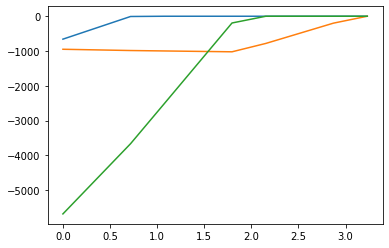

In [325]:
mcorr = np.array(
    [
        [1.00, 0.26, 0.41, 0.57],
        [0.26, 1.00, 0.19, 0.33],
        [0.41, 0.19, 1.00, 0.52],
        [0.57, 0.33, 0.52, 1.00]
    ])
    
vol = np.array([0.01531293, 0.01802784, 0.02480944, 0.01251876])
#vol = vol/vol
mcov = np.diag(vol) @ mcorr @ np.diag(vol)

p = putils.Portfolio(np.array([10000, 0, 0, 0]))
C = np.abs(p.pos).sum() * 10 / 10000
tc = np.ones(4) * 2 / 10000

p_var = putils.portfolio_var(p, mcov)
print('Sharpe P: {}'.format(C/np.sqrt(p_var)) )
print('Bank P: {}'.format(C))
hdg = putils.mvp_hedge(p, mcov)
mvp = p + hdg
mvp_var = putils.portfolio_var(mvp, mcov)
print("========= Theory Hedge =========")
print('weights: {}'.format(np.around(mvp.pos, 0))  )
hcost = (tc*np.abs(hdg.pos)).sum()
print('Sharpe: {}'.format( (C-hcost)/np.sqrt(mvp_var)) )
print('HdgCost: {:.2f}%'.format(100*hcost/C))
print('VarRem: {:.2f}%'.format(100*mvp_var/p_var))


def objf(wh):
    hdg = putils.Portfolio(np.concatenate([[0], wh]))
    transc = (tc * np.abs(hdg.pos)).sum()
    nom = C - transc
    phdg = hdg + p
    denom = putils.portfolio_var(phdg, mcov)
    return -nom / np.sqrt(denom)
    #return -(nom - (denom))
    
def lasso(wh, lambd):
    hdg = putils.Portfolio(np.concatenate([[0], wh]))
    #transc = (tc * np.abs(hdg.pos)).sum()
    #nom = C - transc
    phdg = hdg + p
    denom = putils.portfolio_var(phdg, mcov)
    return denom + lambd*np.abs(hdg.pos).sum()
    
print('')
print("========= Optim =========")
from scipy.optimize import minimize
x0 = hdg.pos[1::]
x0 = np.zeros(3)
routine = 'Nelder-Mead'; opt = {'disp': True, 'fatol':1e-4, 'maxiter':2000}
#routine = 'BFGS'; opt = {'disp': True, 'gtol':1e-6}
#routine = 'Powell'; opt = {'disp': True, 'ftol':1-3, 'maxiter':5000}
res = minimize(objf, x0, method=routine, options=opt)
hdg = putils.Portfolio(np.concatenate([[0], res.x]))
hp = p + hdg
hp_var = putils.portfolio_var(hp, mcov)
hcost = (tc*np.abs(hdg.pos)).sum()
print('weights: {}'.format(np.around(hp.pos, 0))  )
print('Sharpe HP: {}'.format( (C-hcost)/np.sqrt(hp_var)) )
print('HdgCost: {:.4f}%'.format(100*hcost/C))
print('Var Rem: {:.4f}%'.format(100*hp_var/p_var))

print('')

hdg2 = putils.Portfolio(np.array([0, 0, 0, -4461.25]))
hp2 = p + hdg2
hp_var = putils.portfolio_var(hp2, mcov)
hcost = (tc*np.abs(hdg2.pos)).sum()
print('weights: {}'.format(np.around(hp2.pos, 0))  )
print('Sharpe HP: {}'.format( (C-hcost)/np.sqrt(hp_var)) )
print('HdgCost: {:.4f}%'.format(100*hcost/C))
print('Var Rem: {:.4f}%'.format(100*hp_var/p_var))

print('')    
# Test lasso
def penaltyUB():
    tmp = mcov - np.diag(np.diag(mcov))
    return np.max(np.abs(tmp))*10000*2
    

print(mcov*20000)
lass = np.linspace(0, penaltyUB(), 10)
x0 = np.zeros(3)
data = np.zeros((lass.shape[0], 4))
routine = 'Nelder-Mead'; opt = {'disp': False, 'fatol':1e-4, 'maxiter':2000}
for i in range(lass.shape[0]):
    res = minimize(lasso, x0, args=(lass[i]), method=routine, options=opt)
    x0 = res.x.copy()
    data[i, 0] = lass[i]
    data[i, 1] = res.x[0]
    data[i, 2] = res.x[1]
    data[i, 3] = res.x[2]
    
from matplotlib import pyplot as plt
plt.plot(data[:,0], data[:,1::])
plt.show()
